# importing all necessary libraries.

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the training dataset and separating features and reponse.

In [4]:
prices_train = pd.read_csv("D:\intern project\machineHack\Predicting-House-Prices-In-Bengaluru-Train-Data.csv")

In [5]:
prices_train.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
prices_train.shape

(13320, 9)

In [7]:
prices_train.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [8]:
X = prices_train.drop('price',axis=1)

In [9]:
y_true = prices_train['price']

In [10]:
X.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0


In [11]:
y_true.head()

0     39.07
1    120.00
2     62.00
3     95.00
4     51.00
Name: price, dtype: float64

In [12]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0


# Data Cleaning

# Total_sqft cleaned

In [13]:
ch = ['-','S','P','A','G','C']
sam = X['total_sqft']
for i in ch:
    sam = sam.apply(lambda x: (x.split(i)))
    sam = sam.apply(lambda x: x[0])
    
X['total_sqft'] = (sam.apply(lambda x: pd.to_numeric(x)))

## visualizing the initial dataset.

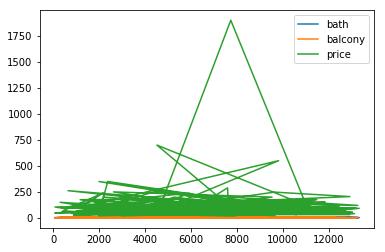

In [14]:
prices_train.sample(250).plot()

# scaling the features

In [15]:
col_to_norm = ['total_sqft', 'bath', 'balcony']

In [16]:
X[col_to_norm] = X[col_to_norm].apply(lambda x: (x-x.min())/(x.max()-x.min()))

In [17]:
X.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,0.020183,0.025641,0.333333
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,0.049722,0.102564,1.000000
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,0.027530,0.025641,1.000000
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,0.029079,0.051282,0.333333
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,0.022938,0.025641,0.333333


In [18]:
(pd.isna(X)).sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
dtype: int64

In [19]:
X["location"].fillna(" ", inplace = True)
X["size"].fillna(" ", inplace = True)
X["society"].fillna(" ", inplace = True)
X["bath"].fillna((X['bath'].mean()), inplace = True)
X["balcony"].fillna((X['balcony'].mean()), inplace = True)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=18)

In [22]:
X_test.shape

(3996, 8)

In [23]:
area_type = tf.feature_column.categorical_column_with_hash_bucket('area_type',hash_bucket_size=10)
availability = tf.feature_column.categorical_column_with_hash_bucket('availability',hash_bucket_size=10000)
location = tf.feature_column.categorical_column_with_hash_bucket('location',hash_bucket_size=100000)
size = tf.feature_column.categorical_column_with_hash_bucket('size',hash_bucket_size=100)
society = tf.feature_column.categorical_column_with_hash_bucket('society',hash_bucket_size=100000)
total_sqft = tf.feature_column.numeric_column('total_sqft')
bath = tf.feature_column.numeric_column('bath')
balcony = tf.feature_column.numeric_column('balcony')

In [28]:
emb_area_type = tf.feature_column.embedding_column(area_type,dimension=4)
emb_availability = tf.feature_column.embedding_column(availability,dimension=1000)
emb_location = tf.feature_column.embedding_column(location,dimension=1000)
emb_size = tf.feature_column.embedding_column(size,dimension=1000)
emb_society = tf.feature_column.embedding_column(society,dimension=1000)

In [29]:
feat_cols = [emb_area_type,emb_availability,emb_location,emb_size,emb_society,total_sqft,bath,balcony]

In [30]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)

In [31]:
model = tf.estimator.DNNRegressor(hidden_units=[8,8,8],feature_columns=feat_cols)
#model = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Chas\\AppData\\Local\\Temp\\tmpuzv8e8cm', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [32]:
model.train(input_fn=input_func,steps = 10000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Chas\AppData\Local\Temp\tmpuzv8e8cm\model.ckpt.
INFO:tensorflow:loss = 156160.38, step = 1
INFO:tensorflow:global_step/sec: 76.8005
INFO:tensorflow:loss = 65952.5, step = 101 (1.321 sec)
INFO:tensorflow:global_step/sec: 88.0231
INFO:tensorflow:loss = 15071.508, step = 201 (1.097 sec)
INFO:tensorflow:global_step/sec: 94.4233
INFO:tensorflow:loss = 18689.865, step = 301 (1.060 sec)
INFO:tensorflow:global_step/sec: 94.2453
INFO:tensorflow:loss = 5328.192, step = 401 (1.062 sec)
INFO:tensorflow:global_step/sec: 95.3234
INFO:tensorflow:loss = 39983.117, step = 501 (1.050 sec)
INFO:tensorflow:global_step/sec: 93.8913
INFO:tensorflow:loss = 84152.01, step = 601 (1.064 sec)
INFO:tensorflow:global_step/sec: 89.1214
INFO:tensorflow:loss = 27521.102, step = 701 (1.123 sec)
INFO:tensorflow:global_step/sec: 94.4233
INFO:tensorflow:loss = 75652.6, step = 801 (1.058 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:loss = 311280.12, step = 8201 (1.249 sec)
INFO:tensorflow:global_step/sec: 81.9625
INFO:tensorflow:loss = 11753.97, step = 8301 (1.220 sec)
INFO:tensorflow:global_step/sec: 91.4861
INFO:tensorflow:loss = 29102.633, step = 8401 (1.105 sec)
INFO:tensorflow:global_step/sec: 80.1236
INFO:tensorflow:loss = 8564.922, step = 8501 (1.234 sec)
INFO:tensorflow:global_step/sec: 86.8006
INFO:tensorflow:loss = 20970.963, step = 8601 (1.155 sec)
INFO:tensorflow:global_step/sec: 85.1015
INFO:tensorflow:loss = 98686.93, step = 8701 (1.172 sec)
INFO:tensorflow:global_step/sec: 84.526
INFO:tensorflow:loss = 12800.707, step = 8801 (1.185 sec)
INFO:tensorflow:global_step/sec: 82.3676
INFO:tensorflow:loss = 10401.716, step = 8901 (1.213 sec)
INFO:tensorflow:global_step/sec: 85.1015
INFO:tensorflow:loss = 2204.9949, step = 9001 (1.174 sec)
INFO:tensorflow:global_step/sec: 85.3194
INFO:tensorflow:loss = 3164.2375, step = 9101 (1.173 sec)
INFO:tensorflow:global_step/sec: 83.6072
INFO:tensorflo

## prediction to find rmse

In [33]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=10,num_epochs=1,shuffle=False)

In [34]:
pred_gen = model.predict(predict_input_func)

In [35]:
predictions = list(pred_gen)

INFO:tensorflow:Restoring parameters from C:\Users\Chas\AppData\Local\Temp\tmpuzv8e8cm\model.ckpt-10000


In [36]:
predictions

[{'predictions': array([47.440838], dtype=float32)},
 {'predictions': array([41.734333], dtype=float32)},
 {'predictions': array([40.099575], dtype=float32)},
 {'predictions': array([151.05426], dtype=float32)},
 {'predictions': array([37.965424], dtype=float32)},
 {'predictions': array([55.704067], dtype=float32)},
 {'predictions': array([136.36224], dtype=float32)},
 {'predictions': array([114.71745], dtype=float32)},
 {'predictions': array([59.616123], dtype=float32)},
 {'predictions': array([87.504166], dtype=float32)},
 {'predictions': array([53.02708], dtype=float32)},
 {'predictions': array([37.32143], dtype=float32)},
 {'predictions': array([88.90059], dtype=float32)},
 {'predictions': array([83.2658], dtype=float32)},
 {'predictions': array([228.1604], dtype=float32)},
 {'predictions': array([55.659603], dtype=float32)},
 {'predictions': array([206.13753], dtype=float32)},
 {'predictions': array([85.06094], dtype=float32)},
 {'predictions': array([23.712551], dtype=float32)},


In [37]:
final_pred = []

for pred in predictions:
    final_pred.append(pred['predictions'])

In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
mean_squared_error(y_test,final_pred)**0.5

129.6480773693619

In [40]:
prices_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


## Now will load the test day and will predict final values

In [41]:
prices_test = pd.read_csv("D:\intern project\machineHack\Predicting-House-Prices-In-Bengaluru-Test-Data.csv")

In [42]:
prices_test.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN


In [43]:
X_eval = prices_test.drop('price',axis=1)

## Data Cleaning for final evalution

In [44]:
ch = ['-','S','P','A','G','C']
sam_eval = X_eval['total_sqft']
for i in ch:
    sam_eval = sam_eval.apply(lambda x: (x.split(i)))
    sam_eval = sam_eval.apply(lambda x: x[0])
    
X_eval['total_sqft'] = (sam_eval.apply(lambda x: pd.to_numeric(x)))

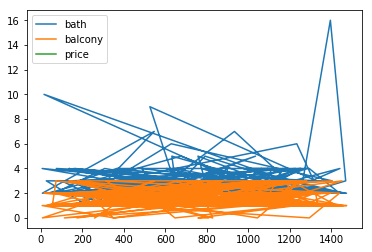

In [45]:
prices_test.sample(250).plot()

In [46]:
X_eval[col_to_norm] = X_eval[col_to_norm].apply(lambda x: (x-x.min())/(x.max()-x.min()))

In [47]:
X_eval.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,0.152595,0.066667,0.666667
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,0.299562,0.533333,0.666667
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,0.205754,0.266667,0.666667
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,0.164728,0.133333,0.333333
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,0.144590,0.066667,0.333333


In [48]:
(pd.isna(X_eval)).sum()

area_type         0
availability      0
location          0
size              2
society         626
total_sqft        0
bath              7
balcony          69
dtype: int64

In [49]:
X_eval["location"].fillna(" ", inplace = True)
X_eval["size"].fillna(" ", inplace = True)
X_eval["society"].fillna(" ", inplace = True)
X_eval["bath"].fillna((X['bath'].mean()), inplace = True)
X_eval["balcony"].fillna((X['balcony'].mean()), inplace = True)

In [50]:
predict_input_func_eval = tf.estimator.inputs.pandas_input_fn(x=X_eval,batch_size=10,num_epochs=1,shuffle=False)

In [51]:
pred_gen_eval = model.predict(predict_input_func_eval)

In [52]:
predictions_eval = list(pred_gen_eval)

INFO:tensorflow:Restoring parameters from C:\Users\Chas\AppData\Local\Temp\tmpuzv8e8cm\model.ckpt-10000


In [53]:
final_pred_eval = []

for pred in predictions_eval:
    final_pred_eval.append(pred['predictions'])

In [54]:
prices_houses= pd.DataFrame({'price' : final_pred_eval})

In [55]:
price_houses =[]
for i in range(len(X_eval)):
    price_houses.append(float(final_pred_eval[i]))

In [56]:
price_houses

[67.38387298583984,
 203.51144409179688,
 162.86585998535156,
 89.34127044677734,
 90.76959228515625,
 94.27732849121094,
 234.206787109375,
 273.0770568847656,
 112.36196899414062,
 102.741455078125,
 87.46332550048828,
 138.6945343017578,
 241.43795776367188,
 104.90594482421875,
 82.83978271484375,
 98.90177917480469,
 43.108585357666016,
 56.133060455322266,
 175.02149963378906,
 194.63328552246094,
 36.35396194458008,
 99.4979248046875,
 97.67443084716797,
 60.4450569152832,
 90.19844055175781,
 166.1287384033203,
 104.49645233154297,
 42.844844818115234,
 213.36236572265625,
 117.5407943725586,
 93.28418731689453,
 90.408935546875,
 92.43719482421875,
 316.6253356933594,
 36.22574234008789,
 73.7679443359375,
 238.51901245117188,
 33.5162467956543,
 213.10452270507812,
 56.74306106567383,
 99.69905090332031,
 95.69355010986328,
 110.48140716552734,
 116.36956787109375,
 140.50146484375,
 69.75056457519531,
 55.33750915527344,
 104.65606689453125,
 172.71334838867188,
 174.4193420

In [57]:
prices_houses = pd.DataFrame({'price':price_houses})

In [58]:
prices_houses.head()

,price
0,67.383873
1,203.511444
2,162.865860
3,89.341270
4,90.769592


In [59]:
prices_houses.to_csv('D:\intern project\machineHack\House_prices_DNNRegressor.csv',index=False)